In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import networkx as nx
from itertools import product

from neuprint import Client,fetch_roi_hierarchy

from config import conf
from dataset_utils import fetch_adjacency, fetch_rois_from_metadata, fetch_rois_from_df, fetch_primary_roi_datasets
from basic_metrics import indegree_mean,outdegree_mean
from utils import find_component_data
from CX_utils import restrict_th,n_comp,n_scomp,comp_sizes,scomp_sizes

from fh import flow_hierarchy
from utils import conn2adj

#RJ code
sys.path.append('recurrence/prepare')
from optimize_ordering import optimize,compute_score


In [2]:
c = Client(conf.neuprint_URL, conf.dataset_version)


In [3]:
rois = ['PB(L1)','PB(L2)','PB(L3)','PB(L4)','PB(L5)','PB(L6)','PB(L7)','PB(L8)','PB(L9)',
        'PB(R1)','PB(R2)','PB(R3)','PB(R4)','PB(R5)','PB(R6)','PB(R7)','PB(R8)','PB(R9)']

n_sum,conn_sum = fetch_adjacency(rois=rois,include_nonprimary=True)
n_0,conn_0 = fetch_adjacency(rois=['PB'],include_nonprimary=True)
#n_total,conn_total = fetch_adjacency(rois=[],include_nonprimary=False)
n_total,conn_total = fetch_adjacency(adjpath='datasets/noncropped_traced')

dataset in adjpath= datasets/noncropped_traced_PB(L1).PB(L2).PB(L3).PB(L4).PB(L5).PB(L6).PB(L7).PB(L8).PB(L9).PB(R1).PB(R2).PB(R3).PB(R4).PB(R5).PB(R6).PB(R7).PB(R8).PB(R9)
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_PB
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced
dataset already downloaded


<h3>PB / split into DAG and recur based on th</h3>

In [235]:
#split into recur/DAG based on th=45
n_list0,adj0 = conn2adj(conn_sum)
mask_recur = ((adj0>5)*1)*((adj0<=45)*1)
mask_DAG = ((adj0>45)*1)

perm_DAG = optimize(adj0*mask_DAG,seed=0,verbose=False)


In [237]:
#recurrence checks
compute_score((adj0*mask_recur)[perm_DAG,:][:,perm_DAG]),compute_score((adj0*mask_DAG)[perm_DAG,:][:,perm_DAG])

(0.39297827930337226, 0.0061417431509212615)

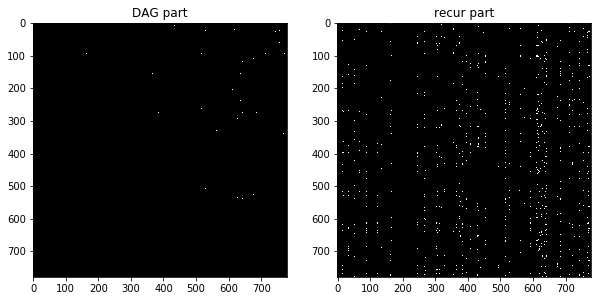

In [242]:
fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(10,5))

axs[0].imshow(((adj0*mask_DAG)[perm_DAG,:][:,perm_DAG])>0*1,cmap='gray')
axs[0].set_title('DAG part')
axs[1].imshow(((adj0*mask_recur)[perm_DAG,:][:,perm_DAG])>0*1,cmap='gray')
axs[1].set_title('recur part')
plt.show()

In [287]:
#compare ordering from th with anatomical ordering

neurons_ordered = {}
neuron_bag = set()
neurons_ordered_a = []
for roi in rois_ordered:
    n = neurons(conn_sum[conn_sum['roi']==roi])    
    neurons_ordered[roi] = set.difference(n,neuron_bag)
    neurons_ordered_a += list(set.difference(n,neuron_bag))
    neuron_bag = set.union(n,neuron_bag)
    
neurons_ordered_b = n_list0[perm_DAG]

In [345]:
#split into recur/DAG based on th=45
n_list0,adj0 = conn2adj(conn_sum)

perm_tot = optimize(adj0,seed=0,verbose=False)


In [346]:
neurons_ordered_c = n_list0[perm_tot]

In [347]:
len(neurons_ordered_a),len(neurons_ordered_b),len(neurons_ordered_c)

(779, 779, 779)

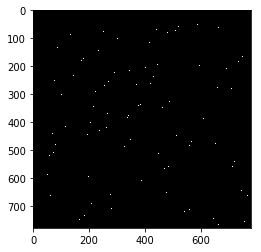

In [348]:
g = nx.Graph()
for na,nb in zip(neurons_ordered_a,neurons_ordered_b):
    g.add_edge(na,nb)
plt.imshow(nx.adjacency_matrix(g).todense(),cmap='gray')
plt.show()

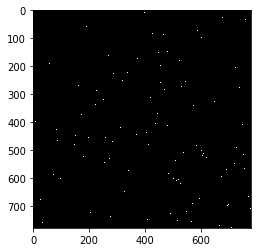

In [351]:
g = nx.Graph()
for na,nc in zip(neurons_ordered_a,neurons_ordered_c):
    g.add_edge(na,nc)
plt.imshow(nx.adjacency_matrix(g).todense(),cmap='gray')
plt.show()

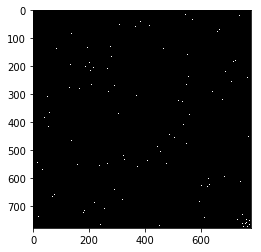

In [352]:
g = nx.Graph()
for na,nc in zip(neurons_ordered_b,neurons_ordered_c):
    g.add_edge(na,nc)
plt.imshow(nx.adjacency_matrix(g).todense(),cmap='gray')
plt.show()

In [334]:
rois_ordered = ['PB(L1)','PB(L2)','PB(L3)','PB(L4)','PB(L5)','PB(L6)','PB(L7)','PB(L8)','PB(L9)'][::-1]+['PB(R1)','PB(R2)','PB(R3)','PB(R4)','PB(R5)','PB(R6)','PB(R7)','PB(R8)','PB(R9)']

# th=200
# th_max=th
# th_min=45

def dice(n1,n2):
    n1 = set(n1)
    n2 = set(n2)
    return 2*len(set.intersection(n1,n2))/(len(n1)+len(n2))

def restrict_conn(conn,th_min,th_max):
    return conn[(conn['weight']>=th_min) & (th_max>conn_sum['weight'])]

def neurons(conn):
    return set(np.concatenate([conn[['bodyId_pre']].values,conn[['bodyId_post']].values]).reshape(-1))

def calc_dice(conn,rois):
    #conn_sum0 = conn_sum[(conn_sum['weight']==11)]
    neurs = []
    for roi in rois:

        c1 = conn[conn['roi']==roi]
        n1 = neurons(c1)
        neurs += [n1]
        #print(roi,'neuros='+str(len(n1)),'synapses='+str(c1.shape[0]))
    
    dice_mat = np.zeros(shape=(len(rois),len(rois)))
    for i,j in product(range(len(rois)),range(len(rois))):
        dice_mat[i,j] = dice(neurs[i],neurs[j])
    return dice_mat



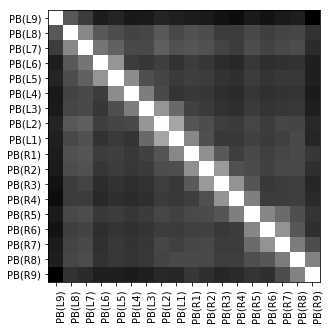

In [344]:
conn_sum0 = restrict_conn(conn_sum,th_min=5,th_max=10000)

dice0 = calc_dice(conn=conn_sum0,rois=rois_ordered)


fig,axs = plt.subplots(figsize=(5,5))

ax=axs
ax.imshow(dice0,cmap='gray')
ax.set_yticks([i for i in range(len(rois_ordered))])
ax.set_xticks([i for i in range(len(rois_ordered))])
ax.set_yticklabels(labels=rois_ordered)
ax.set_xticklabels(labels=rois_ordered)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="anchor")


plt.show()

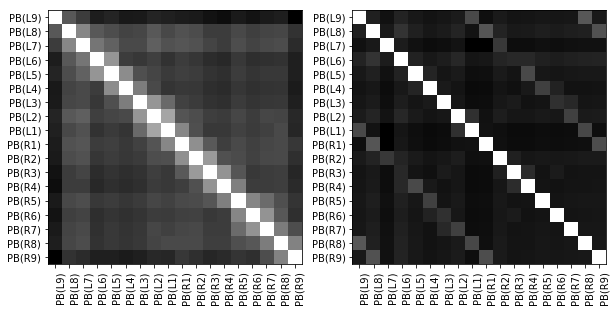

In [335]:
conn_sum0 = restrict_conn(conn_sum,th_min=5,th_max=45)
conn_sum1 = restrict_conn(conn_sum,th_min=45,th_max=10000)

dice0 = calc_dice(conn=conn_sum0,rois=rois_ordered)
dice1 = calc_dice(conn=conn_sum1,rois=rois_ordered)


fig,axs = plt.subplots(ncols=2,figsize=(10,5))

ax=axs[0]
ax.imshow(dice0,cmap='gray')
ax.set_yticks([i for i in range(len(rois_ordered))])
ax.set_xticks([i for i in range(len(rois_ordered))])
ax.set_yticklabels(labels=rois_ordered)
ax.set_xticklabels(labels=rois_ordered)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="anchor")

ax=axs[1]
ax.imshow(dice1,cmap='gray')
ax.set_yticks([i for i in range(len(rois_ordered))])
ax.set_xticks([i for i in range(len(rois_ordered))])
ax.set_yticklabels(labels=rois_ordered)
ax.set_xticklabels(labels=rois_ordered)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="anchor")


plt.show()

In [172]:
conn_sum0.shape,conn_sum1.shape

((10018, 4), (610, 4))

In [176]:
conn_sum0['weight'].sum(),conn_sum1['weight'].sum()

(132459, 39347)

In [234]:
n1 = neurons(conn_sum0)
n2 = neurons(conn_sum1)
dice(n1,n2)

0.5688259109311741

In [232]:
print(len(n2),len(n1))
print(len(neurons(conn_sum.sample(frac=0.012))),len(neurons(conn_sum.sample(frac=0.15))))


281 707
297 710


In [233]:
dice(neurons(conn_sum.sample(frac=0.012)),neurons(conn_sum.sample(frac=0.15)))

0.5581395348837209

<h3>PB / intraconnections </h3>

In [168]:
#inspect all PB interconnections between regions
c_restr = restrict_conn(conn=conn_sum,th_min=5,th_max=10000)
n_restr = set(np.concatenate([c_restr[['bodyId_pre']].values,c_restr[['bodyId_post']].values]).reshape(-1))

szs = []
for i,neur in enumerate(n_restr):
    if i%500==0: print(i)
    t = c[(c['bodyId_pre']==neur) | (c['bodyId_post']==neur)][['roi','weight']].groupby('roi').sum()
    szs += [t.shape[0]]

0
500


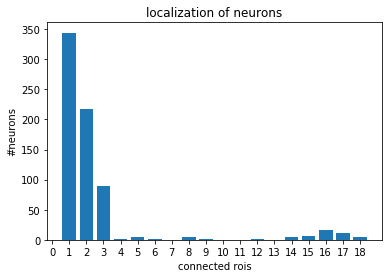

In [169]:
d = pd.Series(szs).value_counts()
plt.bar(d.index,d.values)
plt.xticks([i for i in range(max(d.index)+1)])
plt.title('localization of neurons')
plt.ylabel('#neurons')
plt.xlabel('connected rois')
plt.show()

In [156]:
#inspect small PB interconnections between regions
c_restr = restrict_conn(conn=conn_sum,th_min=5,th_max=45)
n_restr = set(np.concatenate([c_restr[['bodyId_pre']].values,c_restr[['bodyId_post']].values]).reshape(-1))

szs = []
for i,neur in enumerate(n_restr):
    if i%500==0: print(i)
    t = c[(c['bodyId_pre']==neur) | (c['bodyId_post']==neur)][['roi','weight']].groupby('roi').sum()
    szs += [t.shape[0]]

0
500


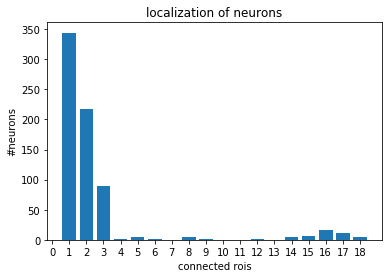

In [161]:
d = pd.Series(szs).value_counts()
plt.bar(d.index,d.values)
plt.xticks([i for i in range(max(d.index)+1)])
plt.title('localization of neurons')
plt.ylabel('#neurons')
plt.xlabel('connected rois')
plt.show()

In [116]:
#inspect large PB interconnections between regions
c_restr = restrict_conn(conn=conn_sum,th_min=45,th_max=10000)
n_restr = set(np.concatenate([c_restr[['bodyId_pre']].values,c_restr[['bodyId_post']].values]).reshape(-1))

szs = []
for i,neur in enumerate(n_restr):
    if i%500==0: print(i)

    t = c[(c['bodyId_pre']==neur) | (c['bodyId_post']==neur)][['roi','weight']].groupby('roi').sum()
    szs += [t.shape[0]]

0


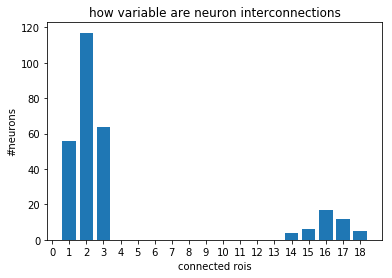

In [155]:
d = pd.Series(szs).value_counts()
plt.bar(d.index,d.values)
plt.xticks([i for i in range(max(d.index)+1)])
plt.title('how variable are neuron interconnections')
plt.ylabel('#neurons')
plt.xlabel('connected rois')
plt.show()

<h3>other</h3>

In [58]:
rois = ['PB(L1)','PB(L2)','PB(L3)','PB(L4)','PB(L5)','PB(L6)','PB(L7)','PB(L8)','PB(L9)',
        'PB(R1)','PB(R2)','PB(R3)','PB(R4)','PB(R5)','PB(R6)','PB(R7)','PB(R8)','PB(R9)']
rois_ordered = ['PB(L1)','PB(L2)','PB(L3)','PB(L4)','PB(L5)','PB(L6)','PB(L7)','PB(L8)','PB(L9)'][::-1]+['PB(R1)','PB(R2)','PB(R3)','PB(R4)','PB(R5)','PB(R6)','PB(R7)','PB(R8)','PB(R9)']

n_sum,conn_sum = fetch_adjacency(rois=rois,include_nonprimary=True)
n_0,conn_0 = fetch_adjacency(rois=['PB'],include_nonprimary=True)
#n_total,conn_total = fetch_adjacency(rois=[],include_nonprimary=False)
n_total,conn_total = fetch_adjacency(adjpath='datasets/noncropped_traced')

dataset in adjpath= datasets/noncropped_traced_PB(L1).PB(L2).PB(L3).PB(L4).PB(L5).PB(L6).PB(L7).PB(L8).PB(L9).PB(R1).PB(R2).PB(R3).PB(R4).PB(R5).PB(R6).PB(R7).PB(R8).PB(R9)
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced_PB
dataset already downloaded
dataset in adjpath= datasets/noncropped_traced
dataset already downloaded


In [73]:
conn_0.shape,conn_sum.shape

((21026, 4), (31353, 4))

In [100]:
x = pd.merge(conn_total[['bodyId_pre','bodyId_post','weight']],conn_0[['bodyId_pre','bodyId_post','weight']],how='inner')

In [87]:
pd.concat([
    conn_0[['bodyId_pre','bodyId_post','weight']],conn_sum[['bodyId_pre','bodyId_post','weight']]
],ignore_index=True,join='inner').drop_duplicates().reset_index(drop=True).shape


(52379, 3)

In [106]:
x = pd.merge(conn_sum[['bodyId_pre','bodyId_post','weight']],conn_0[['bodyId_pre','bodyId_post','weight']],how='inner')

In [68]:
conn = conn_sum
n_comp(conn[(conn['weight']<=45) & (conn['weight']>5)]),n_comp(conn[(conn['weight']>45)])


(1, 1)

In [69]:
conn = conn_0
n_comp(conn[(conn['weight']<=45) & (conn['weight']>5)]),n_comp(conn[(conn['weight']>45)])

(1, 1)

In [47]:
adj0*mask_DAG

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

initial score 0.5985094196397764
score after random permutations 0.37354219860603133
1 1 0.3638120212545718
10 8 0.35366779380305013
28 17 0.3459388586018908
30 1 0.34255744945138356
35 4 0.3321371885998205
37 1 0.321233869298185
52 14 0.3170933682975639
58 5 0.2903181284935476
65 6 0.2870057276930507
91 25 0.2690635566903594
95 3 0.2652680974397901
100 4 0.26133462148920006
102 1 0.257194120488579
104 1 0.2434614588365191
141 36 0.23994203298599118
156 14 0.23669864053550466
160 3 0.22924573873438672
198 37 0.22358705403353793
231 32 0.21785936098267877
282 50 0.21295976813194384
298 15 0.18915188737837266
314 15 0.1712787247256917
323 8 0.1585121799737767
331 7 0.15464771237319702
345 13 0.14912704437236893
392 46 0.1446415016216961
406 13 0.13677454972051606
427 20 0.13235801531985358
430 2 0.12331792146849757
435 4 0.12007452901801106
495 59 0.10875715961631346
583 87 0.10551376716582696
655 71 0.10151128286522658
691 35 0.09806086536470901
698 6 0.09302325581395336
701 2 0.0897108

0.39297827930337226

0.0061417431509212615

Text(0.5, 1.0, 'recur part')

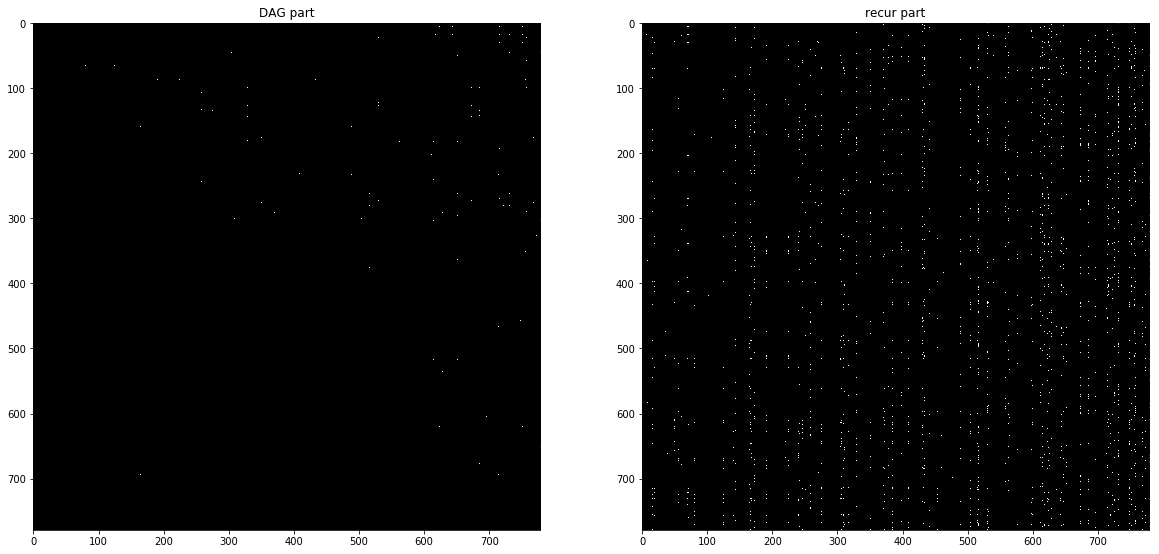

In [10]:
n_list,adj = conn2adj(conn_sum[conn_sum['weight']>45])
perm = optimize(adj,seed=0,verbose=True)

initial score 0.5268729641693811
score after random permutations 0.3557055794893349
1 1 0.34963749080592627
6 4 0.34832405169696334
14 7 0.3465115057265945
20 5 0.3442786592413576
22 1 0.33997057896395927
24 1 0.3396290847956289
29 4 0.33434905957759803
34 4 0.331906062834927
35 0 0.3270988756961228
38 2 0.327020069349585
39 0 0.3258117053693391
40 0 0.3238152779237155
44 3 0.3155143427550699
45 0 0.31296627088368184
47 1 0.3128611957549648
54 6 0.3114689502994641
55 0 0.31128506882420925
61 5 0.3003309866554586
71 9 0.2964432068929284
76 4 0.2919775139224545
79 2 0.2848324051696963
82 2 0.26439529263423345
83 0 0.26142692024797726
84 0 0.26011348113901434
85 0 0.25943049280235364
93 7 0.25139224545550065
94 0 0.2463486392770831
108 13 0.24183040874225067
112 3 0.23996532520752334
113 0 0.23804770410843748
117 3 0.23479037511820947
118 0 0.2334506672270673
122 3 0.23058736996952817
123 0 0.22578018283072393
124 0 0.22286434800882626
125 0 0.21729536618682352
129 3 0.21500998213722805
1

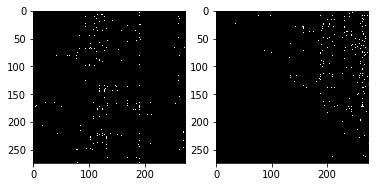

In [13]:
fig,axs = plt.subplots(ncols=2,nrows=1)

axs[0].imshow(adj>0*1,cmap='gray')
axs[1].imshow(adj[perm,:][:,perm]>0*1,cmap='gray')

In [35]:
neur_list_0,adj_0 = conn2adj(conn_0)
perm_0 = optimize(adj_0,seed=0,verbose=False)

In [59]:
perm = {roi:0 for roi in rois}
neur_list = {roi:0 for roi in rois}
adjs = {}
for roi in rois_ordered:
    print(roi)
    n_list,adj = conn2adj(conn_sum[conn_sum['roi']==roi])
    adjs[roi] = adj
    neur_list[roi] = n_list
    perm[roi] = optimize(adj,seed=0,verbose=False)


PB(L9)
PB(L8)
PB(L7)
PB(L6)
PB(L5)
PB(L4)
PB(L3)
PB(L2)
PB(L1)
PB(R1)
PB(R2)
PB(R3)
PB(R4)
PB(R5)
PB(R6)
PB(R7)
PB(R8)
PB(R9)


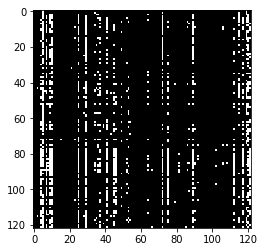

In [69]:

plt.imshow(adjs[rois_ordered[-1]]>0*1,cmap='gray')

In [23]:
compute_score(adj,perm=perm)

0.1273493273175129

In [34]:
compute_score(adj[perm,:][:,perm])

0.1273493273175129

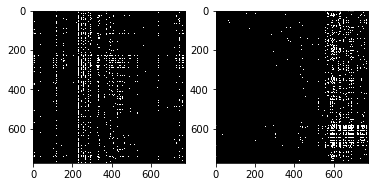

In [33]:
fig,axs = plt.subplots(ncols=2,nrows=1)

axs[0].imshow(adj>0*1,cmap='gray')
axs[1].imshow(adj[perm,:][:,perm]>0*1,cmap='gray')